**GAN (Generative Adversarial Networks)**

generator(画像生成ネットワーク)とdescriminator(真偽判定ネットワーク)という二つのネットワークを競い合わせることで、入力画像の特徴をとらえた画像を生成するという手法

※Google Colab で Google Drvie を使用するための処理

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/

GAN本体

In [0]:
### GAN (Generative Adversarial Networks)
### for mnist

### import
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

### GAN class
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self. channels)

    self.z_dim = 100

    optimizer = Adam(0.0002, 0.5)

    ## discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer = optimizer,
                              metrics = ['accuracy'])

    ## generator
    self.generator = self.build_generator()

    ## combined
    self.combined = self.build_combined()
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer = optimizer)


  def build_discriminator(self):
    img_shape = self.img_shape

    model = Sequential()

    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    model.summary()

    return model

  def build_generator(self):
    noise_shape = (self.z_dim,)

    model = Sequential()

    model.add(Dense(256, input_shape = noise_shape))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(np.prod(self.img_shape), activation = 'tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    return model

  def build_combined(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def train(self, epochs, batch_size=128, save_interval=50):
    (x_train, _), (_, _) = mnist.load_data()

    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis = 3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

      ## train discriminator 
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      ## train generator
      noise = np.random.normal(0, 1, (batch_size, self.z_dim))
      valid_y = np.array([1] * batch_size)
      g_loss = self.combined.train_on_batch(noise, valid_y)

      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]"%(epoch, d_loss[0], 100*d_loss[1], g_loss))

      if epoch % save_interval == 0:
        self.save_imgs(epoch)

  def save_imgs(self, epoch):
    r, c = 5, 5
    
    noise = np.random.normal(0, 1, (r*c, self.z_dim))
    gen_imgs = self.generator.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
        axs[i, j].axis('off')
        cnt += 1
    fig.savefig("/content/drive/My Drive/gan_mnist/mnist_%d.png" % epoch)
    plt.close()

if __name__ == '__main__':
  gan = GAN()
  gan.train(epochs = 30000, batch_size=32, save_interval=500)

以下、生成した画像

上から0epoch, 5000epoch, 29500epoch

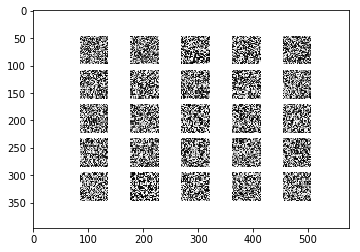

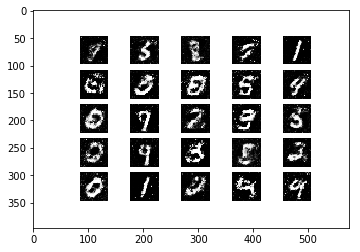

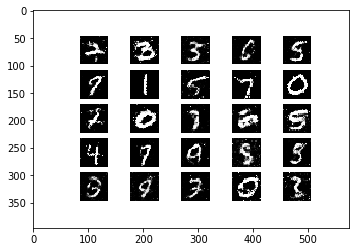

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.asarray(Image.open("/content/drive/My Drive/gan_mnist/mnist_0.png")))
plt.show()
plt.imshow(np.asarray(Image.open("/content/drive/My Drive/gan_mnist/mnist_5000.png")))
plt.show()
plt.imshow(np.asarray(Image.open("/content/drive/My Drive/gan_mnist/mnist_29500.png")))
plt.show()